In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy import stats, spatial
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
#plt.rcParams['font.family'] = 'Arial'

In [2]:
soma_feature = pd.read_csv('../../data/155k_DEN_soma_feature.csv', sep=',', index_col=0)
soma_feature

,x,y,z,source_region,source_region_withCorticalRegion
swc_id,,,,,
SEU-ALLEN_local_15257_10001_19868_8155_CCFv3.swc,11287.600,3667.825,5563.125,fiber tracts,arb
SEU-ALLEN_local_15257_10008_10862_6996_CCFv3.swc,9625.025,3764.025,9017.726,ENTm,ENTm5
SEU-ALLEN_local_15257_10012_10978_7039_CCFv3.swc,9682.675,3754.125,8985.000,ENTm,ENTm5
SEU-ALLEN_local_15257_10020_17924_8129_CCFv3.swc,11267.750,3630.950,6364.775,fiber tracts,arb
SEU-ALLEN_local_15257_10028_28224_6732_CCFv3.swc,9298.925,3983.150,2374.200,SUB,SUB
...,...,...,...,...,...
SEU-ALLEN_local_236174_7626_18076_3068_CCFv3.swc,3998.550,1907.975,5585.175,ACAd,ACAd1
SEU-ALLEN_local_236174_8122_17844_3762_CCFv3.swc,4842.475,2017.425,5512.275,ACAd,ACAd2/3
SEU-ALLEN_local_236174_8813_17916_4826_CCFv3.swc,5990.175,2143.925,5498.300,ACAv,ACAv2/3


In [3]:
swc_dict = {}
file_path = '../../data/processed_neuron_nmo'
swc_list = os.listdir(file_path)

den_contact = pd.DataFrame()

for i in tqdm(swc_list):
    tmp_swc = pd.read_csv(file_path+'/'+i, 
                        sep=' ', index_col=0, skiprows=1, header=None, 
                        names=['##n', 'type', 'x', 'y', 'z', 'r', 'parent', 
                               'spine','inh'],
                        usecols=[0,1,2,3,4,5,6, 
                                 7, 8]
                       )
    tmp_swc = tmp_swc[['type', 'x', 'y', 'z', 'r', 'parent', 'spine', 'inh']]
    tmp_swc['synapse'] = -1
    tmp_swc.loc[tmp_swc[tmp_swc['spine']>0].index, 'synapse'] = 1
    tmp_swc.loc[tmp_swc[tmp_swc['inh']>0].index, 'synapse'] = 1

    tmp_contact = tmp_swc[tmp_swc['synapse'] == 1].copy()
    tmp_contact['cell_id'] = i
    
    den_contact = pd.concat([den_contact, 
                             tmp_contact[['x', 'y', 'z', 'spine', 'cell_id']]
                            ], 
                            axis=0)
    
    swc_dict[i] = tmp_swc

den_contact.reset_index(inplace=True)

swc_dict['processed_Neuron-1-E-and-I-synapses.eswc.swc']

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.80it/s]


,type,x,y,z,r,parent,spine,inh,synapse
##n,,,,,,,,,
1,0,880.493,1097.10,135.703,58.623,2,-1.0,-1.0,-1
2,1,880.050,1097.10,135.260,59.000,-1,-1.0,-1.0,-1
3,0,881.200,1097.10,136.411,58.021,1,-1.0,-1.0,-1
4,0,880.050,1096.51,135.357,58.864,2,-1.0,-1.0,-1
5,0,880.558,1096.59,135.260,58.784,2,-1.0,-1.0,-1
...,...,...,...,...,...,...,...,...,...
40674,5,842.910,4326.85,-408.558,2.615,40673,1.0,-1.0,1
40675,5,842.940,4326.52,-409.502,2.506,40674,1.0,-1.0,1
40676,5,842.980,4326.19,-410.447,2.397,40675,-1.0,-1.0,-1


In [4]:
den_contact

,##n,x,y,z,spine,cell_id
0,88,880.050,1082.70,137.685,-1.0,processed_Neuron-1-E-and-I-synapses.eswc.swc
1,470,879.947,1140.76,190.025,-1.0,processed_Neuron-1-E-and-I-synapses.eswc.swc
2,512,879.884,1141.67,195.928,1.0,processed_Neuron-1-E-and-I-synapses.eswc.swc
3,519,879.872,1141.78,196.922,1.0,processed_Neuron-1-E-and-I-synapses.eswc.swc
4,534,868.690,1153.42,180.339,-1.0,processed_Neuron-1-E-and-I-synapses.eswc.swc
...,...,...,...,...,...,...
89217,41913,-1141.070,1388.88,-95.849,1.0,processed_Neuron-9-E-and-I-synapses.eswc.swc
89218,41914,-1141.950,1388.76,-95.382,-1.0,processed_Neuron-9-E-and-I-synapses.eswc.swc
89219,41915,-1142.710,1388.59,-94.842,1.0,processed_Neuron-9-E-and-I-synapses.eswc.swc
89220,41916,-1142.970,1388.16,-93.978,1.0,processed_Neuron-9-E-and-I-synapses.eswc.swc


In [5]:
if not os.path.exists('../../data/postsynapse_from_Iascone_data.csv'):
    tmp_results = []
    
    for i in tqdm(swc_list):
        tmp_swc = swc_dict[i]
        tmp_ct = tmp_swc['parent'].value_counts()
        tmp_ct = tmp_ct[tmp_ct>=2]
        tmp_branch_index = list(tmp_ct.index)
    
        tmp_den = den_contact[den_contact['cell_id'] == i].copy()
        
        for j in tmp_den.index:
            cur_index = tmp_den.loc[j, '##n']
            tmp_n_branch = 1
            while cur_index != -1:
                cur_index = tmp_swc.loc[cur_index, 'parent']
                if cur_index in tmp_branch_index:
                    tmp_n_branch = tmp_n_branch + 1
            tmp_results.append([j, tmp_n_branch])
    
    den_contact['branch_level'] = -1
    i = [xi[0] for xi in tmp_results]
    j = [xi[1] for xi in tmp_results]
    den_contact.loc[i, 'branch_level'] = j
    den_contact['count'] = 1
    
    pt1 = den_contact.pivot_table(index='cell_id', columns=['branch_level'], 
                            values=['count'], aggfunc='sum', fill_value=0
                           )
    
    pt1.columns.name = ''
    pt1.columns = [i[1] for i in pt1.columns]
    #pt1.index.name = ''
    
    pt1 = pt1.reset_index()
    
    # pt1['soma_region'] = pt1['target_cell'].map(soma_feature['source_region'].to_dict())
    
    pt1 = pt1.set_index('cell_id', )
    pt1[1] = 0
    pt1 = pt1[list(range(1,11))]
    pt1.to_csv('../../data/postsynapse_from_Iascone_data.csv', sep=',')
    
else:
    pt1 = pd.read_csv('../../data/postsynapse_from_Iascone_data.csv', sep=',')
    pt1 = pt1.set_index('cell_id')
    
pt1

,1,2,3,4,5,6,7,8,9,10
cell_id,,,,,,,,,,
processed_Neuron-1-E-and-I-synapses.eswc.swc,0,52,1645,1742,784,1176,655,282,141,636
processed_Neuron-10-E-and-I-synapses.eswc.swc,0,6,24,229,1773,2276,1747,896,99,212
processed_Neuron-11-E-synapses.eswc.swc,0,7,186,228,1404,2397,1472,107,303,213
processed_Neuron-12-E-synapses.eswc.swc,0,0,22,777,1131,1138,570,246,458,583
processed_Neuron-2-E-and-I-synapses.eswc.swc,0,1,202,239,1005,2611,811,898,598,173
processed_Neuron-3-E-and-I-synapses.eswc.swc,0,3,23,457,873,1123,1149,1099,572,139
processed_Neuron-4-E-and-I-synapses.eswc.swc,0,1,123,356,1369,2619,860,490,343,246
processed_Neuron-5-E-and-I-synapses.eswc.swc,0,10,25,518,1399,2174,272,367,463,150
processed_Neuron-6-E-and-I-synapses.eswc.swc,0,129,19,51,552,1647,1340,1092,1132,643


In [6]:
pt1.stack().reset_index()

,cell_id,level_1,0
0,processed_Neuron-1-E-and-I-synapses.eswc.swc,1,0
1,processed_Neuron-1-E-and-I-synapses.eswc.swc,2,52
2,processed_Neuron-1-E-and-I-synapses.eswc.swc,3,1645
3,processed_Neuron-1-E-and-I-synapses.eswc.swc,4,1742
4,processed_Neuron-1-E-and-I-synapses.eswc.swc,5,784
...,...,...,...
115,processed_Neuron-9-E-and-I-synapses.eswc.swc,6,1060
116,processed_Neuron-9-E-and-I-synapses.eswc.swc,7,2289
117,processed_Neuron-9-E-and-I-synapses.eswc.swc,8,1936
118,processed_Neuron-9-E-and-I-synapses.eswc.swc,9,578


In [7]:
pt2 = pt1.stack().reset_index()
# pt2 = pt2[1:]
pt2.columns = ['target_cell', 'branch_level', 'counts']
pt2['branch_level'] = pt2['branch_level'].astype(int)

pt2

,target_cell,branch_level,counts
0,processed_Neuron-1-E-and-I-synapses.eswc.swc,1,0
1,processed_Neuron-1-E-and-I-synapses.eswc.swc,2,52
2,processed_Neuron-1-E-and-I-synapses.eswc.swc,3,1645
3,processed_Neuron-1-E-and-I-synapses.eswc.swc,4,1742
4,processed_Neuron-1-E-and-I-synapses.eswc.swc,5,784
...,...,...,...
115,processed_Neuron-9-E-and-I-synapses.eswc.swc,6,1060
116,processed_Neuron-9-E-and-I-synapses.eswc.swc,7,2289
117,processed_Neuron-9-E-and-I-synapses.eswc.swc,8,1936
118,processed_Neuron-9-E-and-I-synapses.eswc.swc,9,578


In [8]:
pt2 = pt1.copy()
# total_points = pt2.sum().sum()
# print(total_points)

# pt2 = pt2 / total_points
pt2

,1,2,3,4,5,6,7,8,9,10
cell_id,,,,,,,,,,
processed_Neuron-1-E-and-I-synapses.eswc.swc,0,52,1645,1742,784,1176,655,282,141,636
processed_Neuron-10-E-and-I-synapses.eswc.swc,0,6,24,229,1773,2276,1747,896,99,212
processed_Neuron-11-E-synapses.eswc.swc,0,7,186,228,1404,2397,1472,107,303,213
processed_Neuron-12-E-synapses.eswc.swc,0,0,22,777,1131,1138,570,246,458,583
processed_Neuron-2-E-and-I-synapses.eswc.swc,0,1,202,239,1005,2611,811,898,598,173
processed_Neuron-3-E-and-I-synapses.eswc.swc,0,3,23,457,873,1123,1149,1099,572,139
processed_Neuron-4-E-and-I-synapses.eswc.swc,0,1,123,356,1369,2619,860,490,343,246
processed_Neuron-5-E-and-I-synapses.eswc.swc,0,10,25,518,1399,2174,272,367,463,150
processed_Neuron-6-E-and-I-synapses.eswc.swc,0,129,19,51,552,1647,1340,1092,1132,643


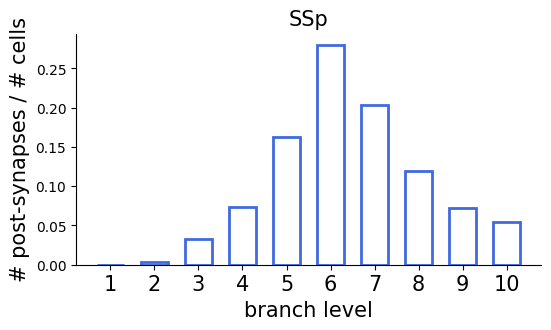

In [9]:
f,ax = plt.subplots(1,1,figsize=(6,3))
plt.bar([str(i) for i in pt2.columns], 
        list(pt2.mean(axis=0) / (np.sum(pt2.mean()))),
        width=0.6, edgecolor='royalblue', color='none',
        linewidth=2,
       )

# plt.errorbar([str(i) for i in pt2.columns], 
#             list(pt2.mean(axis=0)),
#             list(pt2.std(axis=0)/ np.sqrt(12)), #  / np.sqrt(12)
#               marker=',', linestyle='None'
#             )

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

ax.set_xlabel('branch level', fontsize=15)
ax.set_ylabel('# post-synapses / # cells', fontsize=15)
plt.title('SSp', fontsize=15)

ax.set_xticks([int(i)-1 for i in pt2.columns],
              [str(i) for i in pt2.columns], 
              fontsize=15, rotation=0)

# ax.set_yticks([0, 5e-3, 10e-3, 15e-3, 20e-3, 25e-3],
#               [0, 5e-3, 10e-3, 15e-3, 20e-3, 25e-3],
#               fontsize=15, 
#               rotation=0)


In [10]:
den_contact = pd.read_csv('../../data/ppss_from_boutons.csv', sep=',', index_col=0)
ssp_list = ['SSp', 'SSp1', 'SSp2/3', 'SSp4', 'SSp5', 'SSp6a', 'SSp6b', 'SSp-n', 'SSp-n1', 'SSp-n2/3', 'SSp-n4', 'SSp-n5', 'SSp-n6a', 'SSp-n6b', 'SSp-bfd', 'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b', 'VISrll', 'VISrll1', 'VISrll2/3', 'VISrll4', 'VISrll5', 'VISrll6a', 'VISrll6b', 'SSp-ll', 'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b', 'SSp-m', 'SSp-m1', 'SSp-m2/3', 'SSp-m4', 'SSp-m5', 'SSp-m6a', 'SSp-m6b', 'SSp-ul', 'SSp-ul1', 'SSp-ul2/3', 'SSp-ul4', 'SSp-ul5', 'SSp-ul6a', 'SSp-ul6b', 'SSp-tr', 'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b', 'SSp-un', 'SSp-un1', 'SSp-un2/3', 'SSp-un4', 'SSp-un5', 'SSp-un6a', 'SSp-un6b']

ssp_den_contact = den_contact[den_contact['source_region'].isin(ssp_list)].copy()
ssp_den_contact['count'] = 1

pt1 = ssp_den_contact.pivot_table(index='target_cell', columns=['branch_level'], 
                        values=['count'], aggfunc='sum', fill_value=0
                       )
pt1.columns=[i[1] for i in pt1.columns]

pt1 = pt1[list(range(1, 11))]

pt1.to_csv('./SSp_PBs_summary.csv')

In [11]:
pt1

,1,2,3,4,5,6,7,8,9,10
target_cell,,,,,,,,,,
SEU-ALLEN_local_15257_12743_28033_3160_CCFv3.swc,0,0,0,1,0,0,0,0,0,0
SEU-ALLEN_local_15257_12749_28823_3088_CCFv3.swc,0,0,2,0,0,0,0,0,0,0
SEU-ALLEN_local_15257_12750_27682_3064_CCFv3.swc,0,0,0,1,0,0,0,0,0,0
SEU-ALLEN_local_15257_12884_10214_3416_CCFv3.swc,0,1,0,1,0,2,0,0,0,0
SEU-ALLEN_local_15257_12912_9604_3501_CCFv3.swc,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
SEU-ALLEN_local_211541_20759_13394_3977_CCFv3.swc,0,0,0,1,0,0,0,0,0,0
SEU-ALLEN_local_211541_20865_15649_6351_CCFv3.swc,0,0,0,1,1,0,0,0,0,0
SEU-ALLEN_local_211541_21267_15342_5616_CCFv3.swc,0,0,1,2,2,0,0,0,0,0


In [12]:
bouton_pt = pd.read_csv('../../data/SSp_PBs_summary.csv', sep=',', index_col=0)
bouton_pt

,1,2,3,4,5,6,7,8,9,10
target_cell,,,,,,,,,,
SEU-ALLEN_local_15257_12743_28033_3160_CCFv3.swc,0,0,0,1,0,0,0,0,0,0
SEU-ALLEN_local_15257_12749_28823_3088_CCFv3.swc,0,0,2,0,0,0,0,0,0,0
SEU-ALLEN_local_15257_12750_27682_3064_CCFv3.swc,0,0,0,1,0,0,0,0,0,0
SEU-ALLEN_local_15257_12884_10214_3416_CCFv3.swc,0,1,0,1,0,2,0,0,0,0
SEU-ALLEN_local_15257_12912_9604_3501_CCFv3.swc,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
SEU-ALLEN_local_211541_20759_13394_3977_CCFv3.swc,0,0,0,1,0,0,0,0,0,0
SEU-ALLEN_local_211541_20865_15649_6351_CCFv3.swc,0,0,0,1,1,0,0,0,0,0
SEU-ALLEN_local_211541_21267_15342_5616_CCFv3.swc,0,0,1,2,2,0,0,0,0,0


In [13]:
pac_pt = pd.read_csv('../../data/SSp_PACs_summary.csv', sep=',', index_col=0)
pac_pt = pac_pt[[str(i) for i in range(1,11)]]
pac_pt.columns = range(1,11)
pac_pt

,1,2,3,4,5,6,7,8,9,10
target_cell,,,,,,,,,,
SEU-ALLEN_local_15257_12616_28017_3178_CCFv3.swc,31,16,0,4,0,7,0,0,0,0
SEU-ALLEN_local_15257_12743_11648_2981_CCFv3.swc,0,0,1,7,7,0,0,0,0,0
SEU-ALLEN_local_15257_12743_28033_3160_CCFv3.swc,0,0,0,41,3,0,42,0,0,0
SEU-ALLEN_local_15257_12749_28823_3088_CCFv3.swc,0,0,16,0,0,9,2,36,0,0
SEU-ALLEN_local_15257_12750_27682_3064_CCFv3.swc,0,0,12,23,15,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
SEU-ALLEN_local_211541_6023_13597_5563_CCFv3.swc,3,2,6,13,0,7,0,0,0,0
SEU-ALLEN_local_211541_7213_15015_4684_CCFv3.swc,6,11,2,8,27,3,0,0,0,0
SEU-ALLEN_local_211541_7587_13504_3859_CCFv3.swc,0,3,15,8,7,35,23,0,0,0


In [14]:
[str(i) for i in pac_pt.columns]

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

In [15]:
pac_pt.mean(axis=0)

1      1.868586
2      6.697033
3     13.181675
4     17.971030
5     19.614660
6     18.259337
7     14.042583
8      9.867016
9      6.483595
10     3.534729
dtype: float64

In [16]:
(pac_pt.mean(axis=0)).min()

1.868586387434555

(0.0, 0.34)

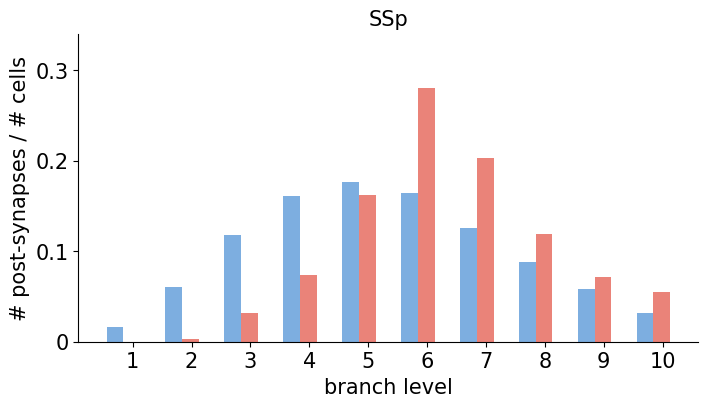

In [17]:
f,ax = plt.subplots(1,1,figsize=(8,4))

pac_mean = pac_pt.mean(axis=0)
bouton_mean = bouton_pt.mean(axis=0)

plt.bar([7*int(i) for i in pac_pt.columns], 
        list((pac_mean) / np.sum(pac_mean)),
        width=2, color='#7DAEE0', #edgecolor='royalblue', 
        linewidth=2,
       )
plt.bar([7*int(i)+2 for i in pt2.columns], 
        list(pt2.mean(axis=0) / (np.sum(pt2.mean()))),
        width=2, color='#EA8379', #edgecolor='royalblue', 
        linewidth=2,
       )

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

ax.set_xlabel('branch level', fontsize=15)
ax.set_ylabel('# post-synapses / # cells', fontsize=15)
plt.title('SSp', fontsize=15)

ax.set_xticks([7*int(i)+2.1 for i in pt2.columns],
              [str(i) for i in pt2.columns], 
              fontsize=15, rotation=0)

ax.set_yticks([0, 0.1, 0.2, 0.3],
              [0, 0.1, 0.2, 0.3],
              fontsize=15, 
              rotation=0)
ax.set_ylim([0, 0.34])


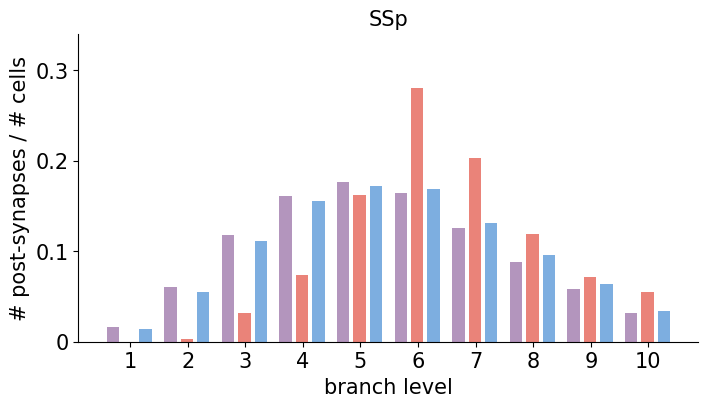

In [21]:
f,ax = plt.subplots(1,1,figsize=(8,4))

pac_mean = pac_pt.mean(axis=0)
bouton_mean = bouton_pt.mean(axis=0)

plt.bar([7*int(i) for i in pac_pt.columns], 
        list((pac_mean) / np.sum(pac_mean)),
        width=1.5, color='#B395BD', #edgecolor='royalblue', 
        linewidth=2,
       )
plt.bar([7*int(i)+2 for i in pt2.columns], 
        list(pt2.mean(axis=0) / (np.sum(pt2.mean()))),
        width=1.5, color='#EA8379', #edgecolor='royalblue', 
        linewidth=2,
       )
plt.bar([7*int(i)+4 for i in bouton_pt.columns], 
        list((bouton_mean) / (np.sum(bouton_mean))),
        width=1.5, color='#7DAEE0', #edgecolor='royalblue', 
        linewidth=2,
       )

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

ax.set_xlabel('branch level', fontsize=15)
ax.set_ylabel('# post-synapses / # cells', fontsize=15)
plt.title('SSp', fontsize=15)

ax.set_xticks([7*int(i)+2.1 for i in pt2.columns],
              [str(i) for i in pt2.columns], 
              fontsize=15, rotation=0)

ax.set_yticks([0, 0.1, 0.2, 0.3],
              [0, 0.1, 0.2, 0.3],
              fontsize=15, 
              rotation=0)
ax.set_ylim([0, 0.34])
plt.savefig('./iascone_cmp.svg', bbox_inches='tight')

In [19]:
print(stats.pearsonr(list((pac_mean) / np.sum(pac_mean)), 
                    list(pt2.mean(axis=0) / (np.sum(pt2.mean()))))
     )

print(stats.pearsonr(list((bouton_mean) / (np.sum(bouton_mean))), 
                    list(pt2.mean(axis=0) / (np.sum(pt2.mean()))))
     )

PearsonRResult(statistic=0.6860518256768574, pvalue=0.028490555922512498)
PearsonRResult(statistic=0.7438725561058585, pvalue=0.01363608017935649)


In [20]:
# print(stats.pearsonr(list((pac_mean - np.min(pac_mean)) / np.sum(pac_mean)), 
#                     list(pt2.mean(axis=0) / (np.sum(pt2.mean()))))
#      )

# print(stats.pearsonr(list((bouton_mean - np.min(bouton_mean)) / (np.sum(bouton_mean))), 
#                     list(pt2.mean(axis=0) / (np.sum(pt2.mean()))))
#      )